In [48]:
import numpy as np
from relaqs import RESULTS_DIR
import qutip
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr


In [82]:
base_path = "/Users/vishchaudhary/rl-repo/results/"
extension_path = "/env_data.csv"

In [110]:
file_path = "2025-01-10_13-16-21"
##x: number of last episodes to visualize
x = 1000
bin_step = 0.1

In [111]:
def preprocess_matrix_string(matrix_str):
    # Step 1: Remove newline characters
    matrix_str = matrix_str.replace('\n', '')
    # Step 2: Add commas where necessary after complex numbers
    matrix_str = matrix_str.replace('j ', 'j, ')
    # Step 3: Return the cleaned string
    matrix_str = matrix_str.replace('] [', '], [')
    return matrix_str

In [112]:
def preprocess_actions(matrix_str):
    matrix_str = matrix_str.strip()

    # Replace multiple spaces with a single comma
    matrix_str = re.sub(r"\s+", ",", matrix_str)

    # Ensure there are no extraneous commas (e.g., "[,0.4,...,]")
    matrix_str = matrix_str.replace("[,", "[").replace(",]", "]")
    return matrix_str

In [113]:
def get_last_episode_step(raw_data):
    # Group by 'Episode Id' and get the last index for each unique episode
    last_indices = raw_data.groupby('Episode Id').tail(1).index.tolist()
    return last_indices

In [114]:
df = pd.read_csv(base_path + file_path + extension_path, header = 0)
last_step = get_last_episode_step(df)
df_filtered = df.loc[last_step].reset_index(drop=True)


In [115]:
preProcessed_u_target = df_filtered.iloc[:, 4].apply(preprocess_matrix_string)
fidelity_array = df_filtered.iloc[:, 0]
preProcessed_actions = df_filtered.iloc[:, 2].apply(preprocess_actions)
u_target_list = [np.array(eval(m)) for m in preProcessed_u_target]
u_target_list = np.array(u_target_list)
actions_array = [np.array(eval(m)) for m in preProcessed_actions]

In [116]:
last_x_u_target = u_target_list[-x:]
last_x_fidelity = fidelity_array[-x:]
last_x_actions = np.array(actions_array[-x:])

Data: 2025-01-10_13-16-21. Last 1000 Episodes. Fidelity >= 0.85


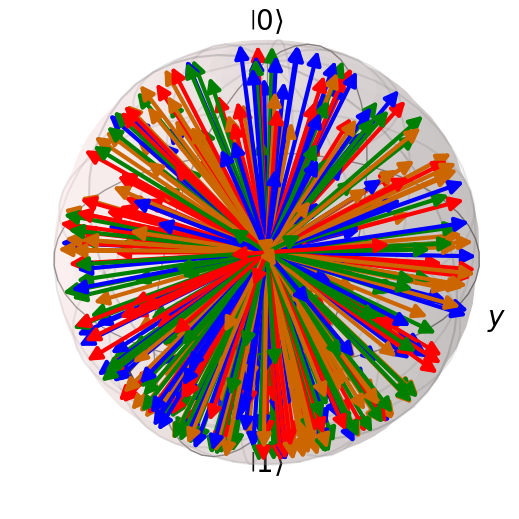

In [129]:
# final_states = [np.matmul(unitary, np.array([1, 0])) for unitary in last_100_self_u]
final_states = []
fidelity_threshold = 0.85
title_string = f'Data: {file_path}. Last {x} Episodes. Fidelity >= {fidelity_threshold}'
for unitary, fidelity in zip(last_x_u_target, last_x_fidelity):
    if fidelity >= fidelity_threshold:
        final_states.append(np.matmul(unitary, np.array([1, 0])))
random_q_objs = [qutip.Qobj(state) for state in final_states]

b = qutip.Bloch()
b.add_states(random_q_objs)
print(title_string)
b.show()

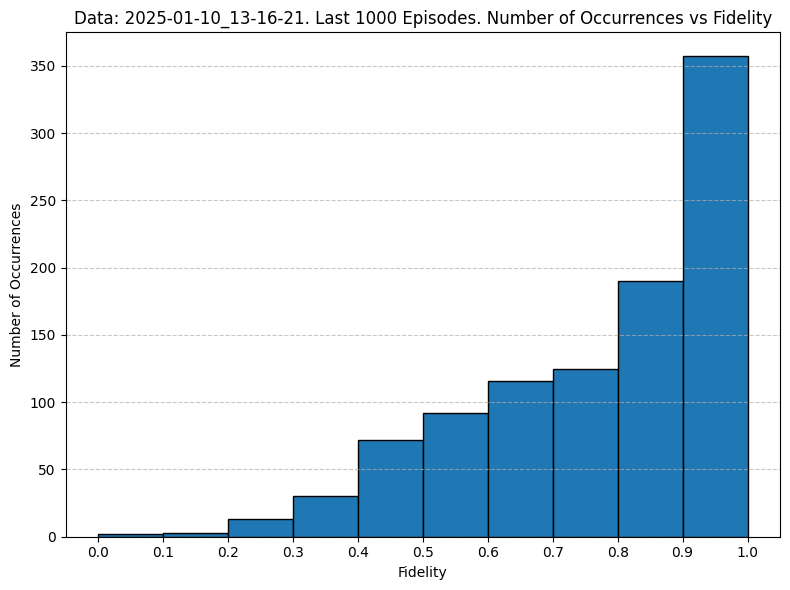

In [130]:
# Define bins for the fidelities with a step of 0.1
bins = np.arange(0.0, 1.1, bin_step)  # Bins from 0.0 to 1.0 with a step of 0.1
count_title = f'Data: {file_path}. Last {x} Episodes. Number of Occurrences vs Fidelity'
# Create a histogram
counts, bin_edges = np.histogram(last_x_fidelity, bins=bins)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(bin_edges[:-1], counts, width=0.1, align='edge', edgecolor='black')

# Add labels and title
plt.xlabel("Fidelity")
plt.ylabel("Number of Occurrences")
plt.title(count_title)
plt.xticks(bins)  # Set the x-axis ticks to match the bins
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [124]:
# 1. Convert to a DataFrame for easier analysis
data = pd.DataFrame({
    "Action_1": last_x_actions[:, 0],
    "Action_2": last_x_actions[:, 1],
    "Action_3": last_x_actions[:, 2],
    "Fidelity": last_x_fidelity
})

# 2. Correlation Analysis
correlations = {}
for col in ["Action_1", "Action_2", "Action_3"]:
    corr, p_value = pearsonr(data[col], data["Fidelity"])
    correlations[col] = {"Correlation": corr, "P-Value": p_value}

print("Correlation Analysis:")
print(pd.DataFrame(correlations).T)

# 3. Linear Regression Analysis
X = last_x_actions
y = last_x_fidelity

# Fit the regression model
model = LinearRegression()
model.fit(X, y)

# Extract coefficients
coefficients = model.coef_

print("\nLinear Regression Coefficients:")
for i, action in enumerate(["Action_1", "Action_2", "Action_3"]):
    print(f"{action}: {coefficients[i]:.4f}")

# 4. Insights
print("\nInsights:")
print("Larger coefficients or correlations (absolute values) indicate stronger impact on fidelity.")
print("P-values help assess the statistical significance of the correlations.")

Correlation Analysis:
          Correlation   P-Value
Action_1    -0.010455  0.741233
Action_2     0.016635  0.599295
Action_3     0.138786  0.000011

Linear Regression Coefficients:
Action_1: 0.1789
Action_2: 0.0072
Action_3: 0.3958

Insights:
Larger coefficients or correlations (absolute values) indicate stronger impact on fidelity.
P-values help assess the statistical significance of the correlations.
